In [2]:
# Cell 1: Imports and specifications
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# --- HARD-CODED USER PARAMETERS ---
# (if BP or RB: fp and fsb should be np.array's of size 2 with frequencies 
# in increasing order. if LP or HP then fp and fsb should be a scalar)
fs       = 40000                # Sampling frequency (Hz)
T = 1 / fs
fp       =  np.array([12000,13000])              # Passband edge (Hz)
fsb      =  np.array([11500,13500])              # Stopband edge (Hz)
Ap       =     1                # Passband ripple (dB)
As       =    40                # Stopband attenuation (dB)
approx   = 'ellip'              # Approximation: 'butter','cheby1','cheby2','ellip'
fshape   = 'bandpass'            # Filter shape: 'lowpass','highpass','bandpass','bandstop'

In [3]:
# Cell 2: Pre-warp digital → analog
# 1) Digital angular frequency rad/s:
omega_p = 2*np.pi * fp 
omega_s = 2*np.pi * fsb
# 2) Pre-warp into analog rad/s:
Omega_p = (2/T) * np.tan(omega_p*T/2)
Omega_s = (2/T) * np.tan(omega_s*T/2)

print("Digital ω_p (rad/s):", omega_p)
print("Digital ω_s (rad/s):", omega_s)
print()
print("Pre-warped analog Ω_p (rad/s):", Omega_p)
print("Pre-warped analog Ω_s (rad/s):", Omega_s)

Digital ω_p (rad/s): [75398.22368616 81681.40899333]
Digital ω_s (rad/s): [72256.63103257 84823.00164692]

Pre-warped analog Ω_p (rad/s): [110110.55363769 130548.1349703 ]
Pre-warped analog Ω_s (rad/s): [101479.51621963 142850.27878032]


In [4]:
# Cell 3: Compute analog prototype order, analog TF
if   approx == 'butter':
    N, Wn = signal.buttord(Omega_p, Omega_s, Ap, As, analog=True)
    b_a, a_a = signal.butter(N, Wn, btype=fshape, analog=True)
elif approx == 'cheby1':
    N, Wn = signal.cheb1ord(Omega_p, Omega_s, Ap, As, analog=True)
    b_a, a_a = signal.cheby1(N, Ap, Wn, btype=fshape, analog=True)
elif approx == 'cheby2':
    N, Wn = signal.cheb2ord(Omega_p, Omega_s, Ap, As, analog=True)
    b_a, a_a = signal.cheby2(N, As, Wn, btype=fshape, analog=True)
elif approx == 'ellip':
    N, Wn = signal.ellipord(Omega_p, Omega_s, Ap, As, analog=True)
    b_a, a_a = signal.ellip(N, Ap, As, Wn, btype=fshape, analog=True)
else:
    raise ValueError("Unsupported approximation method")
print(f"Analog {approx} {fshape} prototype: order={N}, Wn={Wn} rad/s")

Analog ellip bandpass prototype: order=4, Wn=[110110.55363769 130548.1349703 ] rad/s


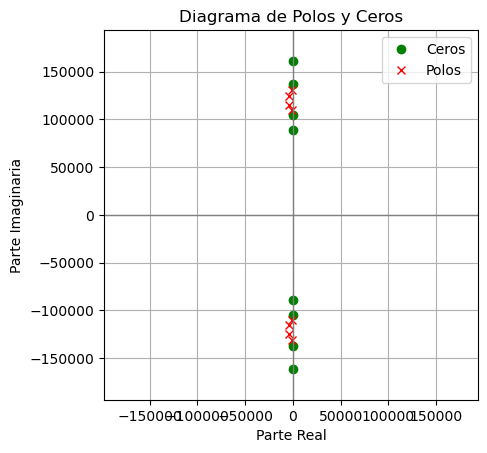

In [12]:

# Obtener ceros, polos y ganancia
z, p, k = signal.tf2zpk(b_a, a_a)

# Crear la figura
fig, ax = plt.subplots()

# Graficar ceros y polos
ax.plot(np.real(z), np.imag(z), 'go', label='Ceros')  # green circle
ax.plot(np.real(p), np.imag(p), 'rx', label='Polos')  # red x

# Líneas guía
ax.axhline(0, color='gray', lw=1)
ax.axvline(0, color='gray', lw=1)

# Calcular límites con margen
all_points = np.concatenate([z, p])
real_vals = np.real(all_points)
imag_vals = np.imag(all_points)

real_margin = 50* (real_vals.max() - real_vals.min() + 1e-3)
imag_margin = 0.1* (imag_vals.max() - imag_vals.min() + 1e-3)

ax.set_xlim(real_vals.min() - real_margin, real_vals.max() + real_margin)
ax.set_ylim(imag_vals.min() - imag_margin, imag_vals.max() + imag_margin)

# Etiquetas y formato
ax.set_title('Diagrama de Polos y Ceros')
ax.set_xlabel('Parte Real')
ax.set_ylabel('Parte Imaginaria')
ax.grid(True)
ax.legend()
ax.set_aspect('equal', 'box')

# Guardar imagen
plt.savefig('pzp_plot.png', dpi=300)
plt.show()
plt.close()

In [6]:
# Cell 4: Bilinear transform → digital filter (signal.bilinear doesn't pre warp)
b_z, a_z = signal.bilinear(b_a, a_a, fs)

print("H(z) numerator  b_z =", b_z)
print()
print("H(z) denominator a_z =", a_z)

H(z) numerator  b_z = [0.01009748 0.02965568 0.0700048  0.10039757 0.12117901 0.10039757
 0.0700048  0.02965568 0.01009748]

H(z) denominator a_z = [ 1.          3.00441509  7.21577921 10.34539309 12.35650289  9.97115716
  6.70320691  2.68968516  0.86286902]


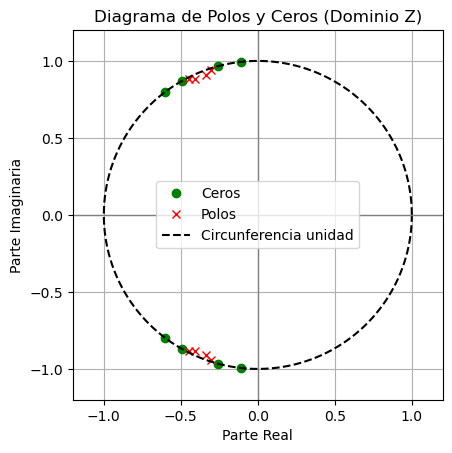

In [7]:
# Obtener ceros, polos y ganancia
z, p, k = signal.tf2zpk(b_z, a_z)

# Crear la figura
fig, ax = plt.subplots()

# Graficar ceros y polos
ax.plot(np.real(z), np.imag(z), 'go', label='Ceros')
ax.plot(np.real(p), np.imag(p), 'rx', label='Polos')

# Circunferencia unidad (importante en sistemas digitales)
theta = np.linspace(0, 2 * np.pi, 500)
ax.plot(np.cos(theta), np.sin(theta), 'k--', label='Circunferencia unidad')

# Líneas guía
ax.axhline(0, color='gray', lw=1)
ax.axvline(0, color='gray', lw=1)

# Ajustar ejes con margen
all_points = np.concatenate([z, p])
real_vals = np.real(all_points)
imag_vals = np.imag(all_points)
margin = 0.2

x_min = min(-1.2, real_vals.min() - margin)
x_max = max(1.2, real_vals.max() + margin)
y_min = min(-1.2, imag_vals.min() - margin)
y_max = max(1.2, imag_vals.max() + margin)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Estética
ax.set_title('Diagrama de Polos y Ceros (Dominio Z)')
ax.set_xlabel('Parte Real')
ax.set_ylabel('Parte Imaginaria')
ax.grid(True)
ax.legend()
ax.set_aspect('equal', 'box')

# Guardar imagen
plt.savefig('pzp_digital.png', dpi=300)
plt.show()
plt.close()

In [8]:
# Cell 4bis: Compute analog unpre-warped TF just for comparison
if   approx == 'butter':
    N, Wn = signal.buttord(omega_p, omega_s, Ap, As, analog=True)
    b_a2, a_a2 = signal.butter(N, Wn, btype=fshape, analog=True)
elif approx == 'cheby1':
    N, Wn = signal.cheb1ord(omega_p, omega_s, Ap, As, analog=True)
    b_a2, a_a2 = signal.cheby1(N, Ap, Wn, btype=fshape, analog=True)
elif approx == 'cheby2':
    N, Wn = signal.cheb2ord(omega_p, omega_s, Ap, As, analog=True)
    b_a2, a_a2 = signal.cheby2(N, As, Wn, btype=fshape, analog=True)
elif approx == 'ellip':
    N, Wn = signal.ellipord(omega_p, omega_s, Ap, As, analog=True)
    b_a2, a_a2 = signal.ellip(N, Ap, As, Wn, btype=fshape, analog=True)
else:
    raise ValueError("Unsupported approximation method")

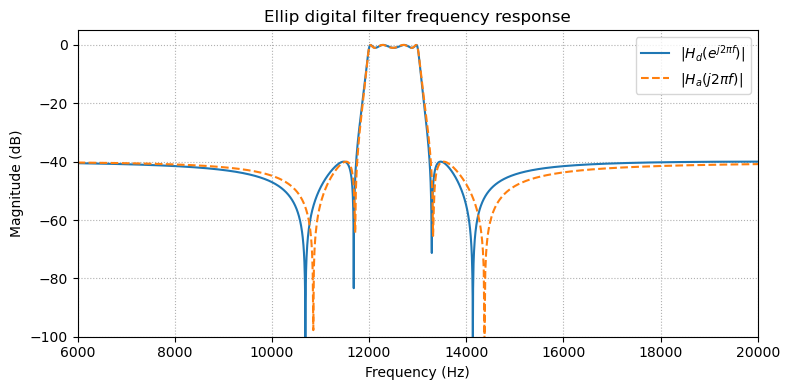

In [10]:
# Cell 5: Plot frequency response
# Digital response 
w_z, h_z = signal.freqz(b_z, a_z, worN=4096, fs=fs)
f_z = w_z

# Analog response (unpre-warped)
w_s, h_s = signal.freqs(b_a2, a_a2, worN=4096)  
f_s = w_s/(2*np.pi)

# Convert to dB
Hz_dB = 20*np.log10(np.abs(h_z) + 1e-12)
Hs_dB = 20*np.log10(np.abs(h_s) + 1e-12)

# Plot both
plt.figure(figsize=(8,4))
plt.plot(f_z, Hz_dB, label=r'$|H_d(e^{j2\pi f})|$')
plt.plot(f_s, Hs_dB, label=r'$|H_a(j2\pi f)|$', linestyle='--')
# give the lines labels so they appear in the legend
if(fshape   != 'bandpass' and fshape != 'bandstop' ):
    plt.axvline(fp,  color='green', linestyle=':', label=r'$f_p$')
    plt.axvline(fsb, color='red',   linestyle=':', label=r'$f_{sb}$')

plt.title(f"{approx.capitalize()} digital filter frequency response")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.ylim(-100, 5)
# tighten the x–range around your region of interest
if(fshape   == 'bandpass' or fshape == 'bandstop' ):
    plt.xlim(fp[0]/2, fs/2)
else:
    plt.xlim(fp/2, fs/2)  
plt.legend(loc='best')
plt.grid(which='both', linestyle=':')
plt.tight_layout()
plt.savefig('BODE_plot.png', dpi=300)
plt.show()
